# Mask RCNN

Dowload required scripts and model from [https://github.com/matterport/Mask_RCNN]

Refer to [http://bunny.swmed.edu:8000/jupyter/user/swan15/notebooks/Mask_RCNN/demo.ipynb]

!!! __REQUIRE__ tensorflow version > 1.3.0 and Keras version > 2.0.5

In [2]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

sys.path.append("/home/swan15/Mask_RCNN")   #### CHANGE THIS PATH TO THE FOLDER OF MASK_RCNN
import utils
import model as modellib
import visualize
from config import Config

import cv2
%matplotlib inline 

# import self-defined image processing functions
from segmentationFunctions import *

# import some image processing functions for dataset augmentation
from PIL import Image
import scipy
from scipy import ndimage

# from Ruichen's watershed code
from skimage import img_as_ubyte, img_as_uint, img_as_float
from skimage import filters
from skimage import measure
from skimage import morphology
from skimage import segmentation
from skimage import color
from skimage import feature
from skimage import io

/home/swan15/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Finetune on the Kaggle training dataset

Refer to [http://bunny.swmed.edu:8000/jupyter/user/swan15/notebooks/Mask_RCNN/train_shapes.ipynb]

In [3]:
class NucleiConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy nuclei dataset.
    """
    # Give the configuration a recognizable name
    NAME = "nuclei"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 4 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + nuclei

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256 # Set to 0 to not resize image in model.model_image_gt
    IMAGE_MAX_DIM = 1024
    IMAGE_PADDING = True
    
    ###### For Anchors ######
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # Length of square anchor side in pixels
    
    # Ratios of anchors at each cell (width/height)
    # A value of 1 represents a square anchor, and 0.5 is a wide anchor
    RPN_ANCHOR_RATIOS = [0.5, 1, 2]
    
    # The strides of each layer of the FPN Pyramid. These values
    # are based on a Resnet101 backbone.
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    
    '''
    # Compute backbone size from input image size
        self.BACKBONE_SHAPES = np.array(
            [[int(math.ceil(self.IMAGE_SHAPE[0] / stride)),
              int(math.ceil(self.IMAGE_SHAPE[1] / stride))]
             for stride in self.BACKBONE_STRIDES])
    '''
    
    # Anchor stride
    # If 1 then anchors are created for each cell in the backbone feature map.
    # If 2, then anchors are created for every other cell, and so on.
    RPN_ANCHOR_STRIDE = 1
    ###### END For Anchors ######

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 230
    
    # Max number of final detections
    DETECTION_MAX_INSTANCES = 300
    
    # Set to a higher ROI positive ratio
    # Percent of positive ROIs used to train classifier/mask heads
    ROI_POSITIVE_RATIO = 0.7
    
    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7

    # Non-maximum suppression threshold for detection ###
    DETECTION_NMS_THRESHOLD = 0.3

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 1000

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    # Learning rate and momentum
    # The Mask RCNN paper uses lr=0.02, but on TensorFlow it causes
    # weights to explode. Likely due to differences in optimzer
    # implementation.
    LEARNING_RATE = 0.00005
    LEARNING_MOMENTUM = 0.9
    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        300
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  5e-05
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFEREN

### Create training dataset

Think to stain Kaggle training set with different colors

In [4]:
def Color_dodge(img_1, img_2):
    img = img_2 / (1.0 - img_1 + 0.001)
    mask_2 = img  > 1
    img = img * (1-mask_2) + mask_2          
    return img

In [5]:
class NucleiDataset(utils.Dataset):
    """Generates the nuclei dataset"""
    """Focus on: 
        image = dataset.load_image(image_id),
        mask, class_ids = dataset.load_mask(image_id),
        """
    def load_images(self, path, augment = 3, resize = 3, rotation = 3):
        """Add existed image pathes and overlapping parameters
        Augment: >= 1, boosting training sample with overlapping random colors;
        Resize: 1~3, streching image horizontally or vertically;
        Rotation: 1~3, rotate image"""
        # Add classes
        self.add_class("nuclei", 1, "nuclei")
        
        # Add images
        files = os.listdir(path)
        imageID = 0
        for i, imagePath in enumerate(files):
            originalImageFile = os.listdir(os.path.join(path, imagePath, 'images'))
            originalImageFilePath = os.path.join(path, imagePath, 'images', originalImageFile[0])
            originalImage = skimage.io.imread(originalImageFilePath)
            height = np.shape(originalImage)[0]
            width = np.shape(originalImage)[1]
            maskPath = os.path.join(path, imagePath, 'masks')
            # Augment through color
            for j in range(augment):
                if j == 0:
                    # Keep the orignal Color for the first image
                    useColorDodge = False
                    overlappingColor = None
                elif j == 1:
                    # Use color_dodge
                    useColorDodge = True
                    overlappingColor = self.randomColor()
                else:
                    # Color overlapping only
                    useColorDodge = False
                    overlappingColor = self.randomColor()
                # Augment through stretching
                for k in range(resize):
                    if k == 0:
                        stretch = None
                    elif k == 1:
                        stretch = "horizontal"
                    elif k == 2:
                        stretch = "vertical"
                    else:
                        stretch = None
                        raise("Warning: resize value > 3")
                    # Augment through rotation
                    for l in range(rotation):
                        if l == 0:
                            rotationDegree = None
                        elif l == 1:
                            # Anti-clockwise rotate 30 degree
                            rotationDegree = 30
                        elif l == 2:
                            # Clockwise rotate 30 degree
                            rotationDegree = -30
                        else:
                            rotationDegree = None
                            raise("Warning: rotation value > 3")
                        self.add_image("nuclei", image_id=imageID, path=originalImageFilePath,
                                       width=width, height=height,
                                       useColorDodge=useColorDodge, overlappingColor=overlappingColor,
                                       stretch=stretch, rotationDegree=rotationDegree,
                                       maskPath=maskPath)
                        imageID = imageID + 1
    
    def randomColor(self):
        nColors = 3*len(self.class_info)
        color = np.array([random.randint(0, 255) for _ in range(nColors)])
        return(color.reshape(2, 3))
    
    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        image = cv2.imread(info['path'])
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        else:
            image = image[:,:,(2,1,0)]
        """Preprocessing can be removed; added 3.26.2018"""
        # Do preprocessing
        if not np.all(image[:,:,0]==image[:,:,1]):
            _, He, _, _ = channelDeconvolution(image, stainingType = "HEB", plotImage = False)
            # 99-2 percentile normalization:
            He = (He - np.percentile(He, 2))/(np.percentile(He, 99) - np.percentile(He, 2))
            np.clip(He, 0, 1, out = He)
            image = np.array(np.transpose(np.array(np.array([He,He,He])*255, dtype=np.uint8), (1,2,0)))
        # Do color overlapping
        if info['overlappingColor'] is not None:
            # Create the mask to overlap with original image
            mask,_ = self.load_mask(image_id, keepOriginal = True)
            mask = np.any(mask, axis=2)
            newMask = np.zeros([np.shape(mask)[0], np.shape(mask)[1], 3], dtype=np.uint8)
            newMask[mask==0] = info['overlappingColor'][0]
            newMask[mask==1] = info['overlappingColor'][1]
            if info['useColorDodge']:
                image = np.array(Color_dodge(image/255.0, newMask/255.0)*255.0, dtype=np.uint8)
            else:
                image = np.array(image/255.0 * newMask, dtype=np.uint8)
        # Do stretching
        if info['stretch'] is not None:
            newWidth = info['width']*2 if info['stretch'] == 'horizontal' else info['width']
            newHeight = info['height']*2 if info['stretch'] == 'vertical' else info['height']
            image = Image.fromarray(image).resize((newWidth, newHeight), Image.NEAREST)
            image = np.array(image, dtype=np.uint8)
        # Do ratation
        if info['rotationDegree'] is not None:
            image = scipy.ndimage.interpolation.rotate(image, info['rotationDegree'], 
                                                axes=(1, 0), reshape=True, output=None, 
                                                order=3, mode='constant', cval=0.0, prefilter=True)
        # Change image type to int and normalize by substracting mean
        image = np.array(image, dtype=float)
        for i in range(3):
            # Min-max normalization:
            # image[:, :, i] = (image[:, :, i] - np.min(image[:, :, i]))*255/(np.max(image[:, :, i]) - np.min(image[:, :, i]))
            # Mean substraction:
            image[:, :, i] = image[:, :, i] - np.mean(image[:, :, i])
        image = np.array(image, dtype=int)
        return image
    
    def load_mask(self, image_id, keepOriginal = False):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        maskFiles = [os.path.join(info['maskPath'], maskFile) for maskFile in os.listdir(info['maskPath'])]
        count = len(maskFiles)
        if count == 0:
            # not maskFiles detected
            return [],[]
        else:
            # Do stretching and rotation when needed
            if not keepOriginal:
                mask0 = np.array(skimage.io.imread(maskFiles[0]), dtype=np.uint8)
                # Do stretching
                if info['stretch'] is not None:
                    newWidth = info['width']*2 if info['stretch'] == 'horizontal' else info['width']
                    newHeight = info['height']*2 if info['stretch'] == 'vertical' else info['height']
                    mask0 = Image.fromarray(mask0)
                    mask0 = np.array(mask0.resize((newWidth, newHeight), Image.NEAREST), dtype=np.uint8)
                # Do rotation
                if info['rotationDegree'] is not None:
                    mask0 = scipy.ndimage.interpolation.rotate(mask0, info['rotationDegree'], 
                                                        axes=(1, 0), reshape=True, output=None, 
                                                        order=2, mode='constant', cval=0.0, prefilter=True)
                mask = np.zeros([np.shape(mask0)[0], np.shape(mask0)[1], count], dtype=np.uint8)
                for i, maskFile in enumerate(maskFiles):
                    mask0 = np.array(skimage.io.imread(maskFile), dtype=np.uint8)
                    if (np.max(mask0) == 255):
                        # Ensure mask value = 0 or 1 in rotation; but bool type does not work, keep type as uint8
                        mask0 = np.array(mask0/255, dtype=np.uint8)
                    # Do stretching
                    if info['stretch'] is not None:
                        newWidth = info['width']*2 if info['stretch'] == 'horizontal' else info['width']
                        newHeight = info['height']*2 if info['stretch'] == 'vertical' else info['height']
                        mask0 = Image.fromarray(mask0)
                        mask0 = np.array(mask0.resize((newWidth, newHeight), Image.NEAREST), dtype=np.uint8)
                    # Do rotation
                    if info['rotationDegree'] is not None:
                        mask0 = scipy.ndimage.interpolation.rotate(mask0, info['rotationDegree'], 
                                                            axes=(1, 0), reshape=True, output=None, 
                                                            order=2, mode='constant', cval=0.0, prefilter=True)
                    mask[:, :, i] = np.array(mask0, dtype=bool)
            else:
                mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
                for i, maskFile in enumerate(maskFiles):
                    mask[:, :, i] = np.array(skimage.io.imread(maskFile), dtype=bool)
            # Handle occlusions
#             occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
#             for i in range(count-2, -1, -1):
#                 mask[:, :, i] = mask[:, :, i] * occlusion
#                 occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
            # All class IDs are 1
            class_ids = np.ones(count, dtype=np.int32)
            return mask, class_ids
        
    def image_reference(self, image_id):
        """Return a link to the image in its source Website or details about
        the image that help looking it up or debugging it.

        Override for your dataset, but pass to this function
        if you encounter images not in your dataset.
        """
        return ""

In [6]:
# Training dataset
dataset_train = NucleiDataset()
dataset_train.load_images(path='/home/swan15/kaggle_2018/data/stage1_train/', augment = 3)
dataset_train.prepare()

In [6]:
# Validation dataset
dataset_val = NucleiDataset()
dataset_val.load_images(path='/home/swan15/kaggle_2018/data/stage1_train/', augment = 1)
dataset_val.prepare()

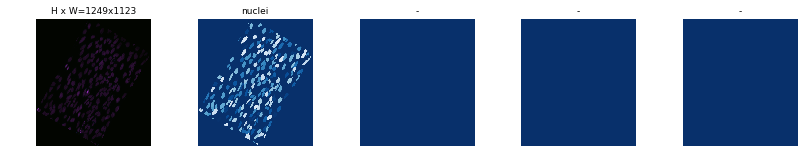

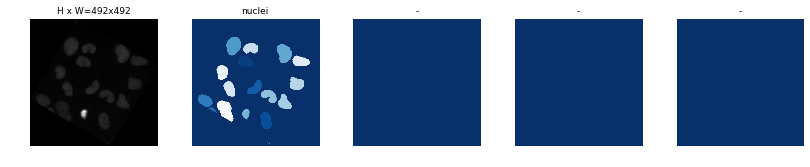

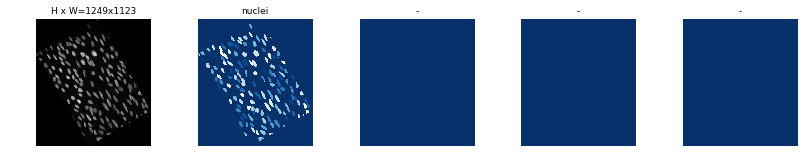

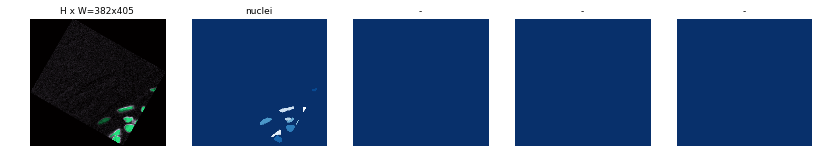

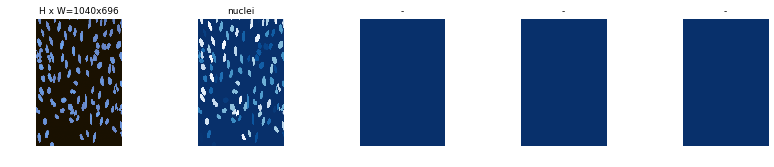

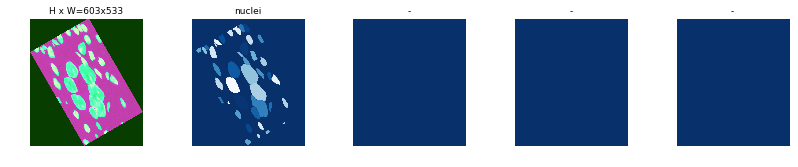

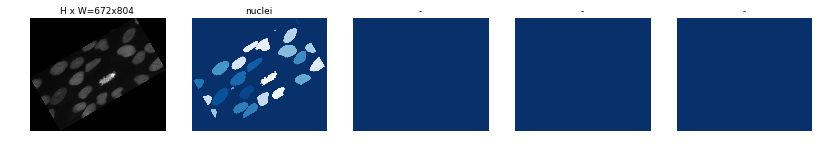

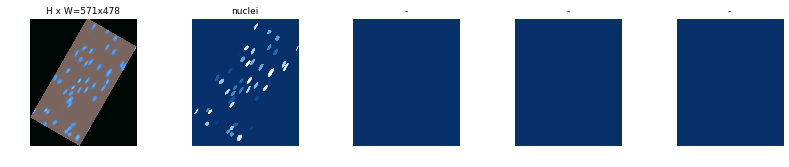

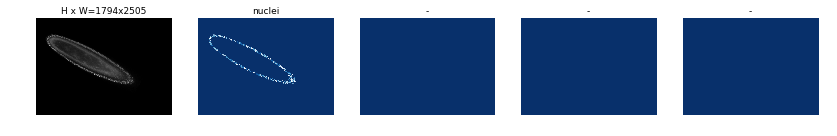

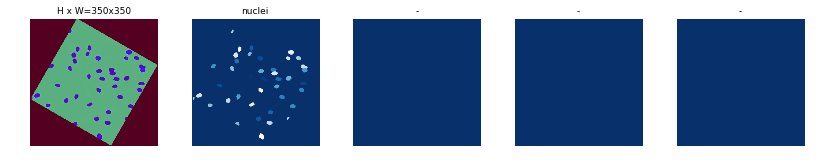

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 10)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    image = (image - np.min(image))*255/(np.max(image) - np.min(image))
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

### Train model

In [22]:
# Create model in training mode
MODEL_DIR = "./mask_RCNN_logs/" # The directory to save logs and trained model
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [23]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last
COCO_MODEL_PATH = "/home/swan15/Mask_RCNN/mask_rcnn_balloon.h5"
LAST_MODEL = "/home/swan15/kaggle_2018/mask_RCNN_logs/nuclei20180327T1929/mask_rcnn_nuclei_0060.h5"

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    # model.load_weights(model.find_last()[1], by_name=True)
    model.load_weights(LAST_MODEL, by_name=True)

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=100, ## epochs to train in total
            layers='heads')

### Detection

In [9]:
test_dirs = os.listdir("./data/stage1_test")
test_filenames=["./data/stage1_test/"+file_id+"/images/"+file_id+".png" for file_id in test_dirs]
test_images=[cv2.imread(imagefile)[:,:,(2,1,0)] for imagefile in test_filenames]
class_names = ['BG', 'nuclei']

In [36]:
class InferenceConfig(NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
inference_config = InferenceConfig()

# Recreate the model in inference mode
MODEL_DIR = "./mask_RCNN_logs/" # The directory to save logs and trained model
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]
model_path = "/home/swan15/kaggle_2018/mask_RCNN_logs/nuclei20180327T1929/mask_rcnn_nuclei_0042.h5"

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/swan15/kaggle_2018/mask_RCNN_logs/nuclei20180327T1929/mask_rcnn_nuclei_0042.h5


In [ ]:
# For all testing images
for i, testImage in enumerate(test_images):
    plt.imshow(testImage)
    plt.show()
    
    # Preprocessing
    if not np.all(testImage[:,:,0]==testImage[:,:,1]):
        _, He, _, _ = channelDeconvolution(testImage, stainingType = "HEB", plotImage = False)
        # Normalize by substracting mean
        # He = He - np.mean(He)*0.75
        # He[He<0] = 0
        He = (He - np.percentile(He, 2))/(np.percentile(He, 99) - np.percentile(He, 2))
        np.clip(He, 0, 1, out = He)
        testImage = np.transpose(np.array(np.array([He,He,He])*255, dtype=np.uint8), (1,2,0))
        print(testImage.shape)
    
    # Normalizing by mean substraction
    testImage0 = testImage.copy()
    testImage = np.array(testImage, dtype=float)
    # testImage = np.array(testImage, dtype=int)
    for j in range(3):
        # testImage[:, :, j] = (testImage[:, :, j] - np.min(testImage[:, :, j]))*255/\
        #       (np.max(testImage[:, :, j]) - np.min(testImage[:, :, j]))
        # testImage[:, :, j] = 255*(testImage[:, :, j] - np.mean(testImage[:, :, j]))/np.std(testImage[:, :, j])
        testImage[:, :, j] = testImage[:, :, j] - np.mean(testImage[:, :, j])
    testImage = np.array(testImage, dtype = np.int)
    
    # Run detection
    results = model.detect([testImage], verbose=1)

    # Visualize results
    r = results[0]
    visualize.display_instances(testImage0, r['rois'], r['masks'], r['class_ids'], 
                                class_names, r['scores'])

##### Combine with image segmentation result

In [15]:
# Mask generation using Otsu thresholding
def showProcessing(img, thresh = None, plotImage = False, fillHole = False):
    """
    input must be a numpy array and 8 bit unsigned integer datatype
    Returns the processed image: mask_holesFilled
    Opening and closing were not considered since they created problems
    """
    if thresh is None:
        # Perform Otsu thresholding
        thresh, mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else: 
        thresh, mask = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)
        
    # Delete Small Objects 
    numPixelsInImage = img.shape[0] * img.shape[1]
    minPixelCount = 2
    mask_smallDeleted = deleteSmallObjects(mask, minPixelCount)
    
    # Fill holes
    if fillHole:
        mask_holesFilled = fillHoles(mask_smallDeleted)
    else:
        mask_holesFilled = mask_smallDeleted  
    
    if plotImage:
        plt.imshow(img)
        plt.title("Original")
        plt.show()

        plt.imshow(mask)
        plt.title("Otsu thresholding")
        plt.colorbar()
        plt.show()

        plt.imshow(mask_smallDeleted)
        plt.title("Small objects deleted")
        plt.show()

    return mask_holesFilled

def generateMask(channel, plotProcess = False, plotResult = False, fillHole = False, normalizeImg = True,
                 originalImg = None, overlapColor = (0, 1, 0), title = "", useWatershed = True,
                 watershedKernelSize = None,
                 saveImg = False, savePath = None, thresh = None):
    """
    Input: channel before normalization
    Input: originalImg for plotting overlapped segmentation result
    Output: binary mask
    """  
    if not checkChannel(channel):
        #if there is not any signal
        nrow, ncol = channel.shape
        mask = np.zeros((nrow, ncol))
        print("No signals detected for this channel")
        return mask
    else:
        channel = removeInfinities(channel)
        #channel[channel < 0] = 0
        if normalizeImg:
            channel = normalize(channel)
        if useWatershed:
            mask_threshold = showProcessing(make8UC(channel), plotImage = plotProcess, fillHole = fillHole, thresh = thresh)
            marker = watershed(mask_threshold, make8UC3(channel), plotImage = plotProcess, kernelSize = watershedKernelSize)     
            # create mask
            mask = np.zeros(marker.shape)
            mask[marker == 1] = 1
            mask = 1-mask
            # Set border as mask from threshold
            mask[0, :] = mask_threshold[0, :] == 255
            mask[-1, :] = mask_threshold[-1, :] == 255
            mask[:, 0] = mask_threshold[:, 0] == 255
            mask[:, -1] = mask_threshold[:, -1] == 255
            if plotResult or saveImg:
                if originalImg is None:
                    #if original image is not provided
                    plt.figure()
                    plt.imshow(mask, cmap = "gray")
                    if plotResult:
                        plt.show()
                else:
                    if len(originalImg.shape) == 3:
                        #create overlapped image
                        #overlappedImg = originalImg.copy()
                        #overlappedImg[marker == -1] = overlapColor
                        overlappedImg = segmentation.mark_boundaries(originalImg, skimage.measure.label(mask), overlapColor, mode = "thick")

                        #if RGB image provided
                        fig, axes = plt.subplots(1, 2, figsize=(15, 15), sharex=True, sharey=True,
                                             subplot_kw={'adjustable': 'box-forced'})
                        ax = axes.ravel()
                        ax[0].imshow(mask, cmap = "gray")
                        ax[0].set_title(str(title)+" Mask")
                        ax[1].imshow(overlappedImg)
                        ax[1].set_title("Overlapped with Original Image")
                        if plotResult:
                            plt.show()         
                    elif len(originalImg.shape) == 2:
                        #create overlapped image
                        #overlappedImg = originalImg.copy()
                        #overlappedImg[marker == -1] = overlapColor
                        overlappedImg = segmentation.mark_boundaries(originalImg, skimage.measure.label(mask), overlapColor, mode = "thick")

                        #if RGB image provided
                        fig, axes = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True,
                                             subplot_kw={'adjustable': 'box-forced'})
                        ax = axes.ravel()
                        ax[0].imshow(mask, cmap = "gray")
                        ax[0].set_title(str(title)+" Mask")
                        ax[1].imshow(overlappedImg, cmap = "gray")
                        ax[1].set_title("Overlapped with Original Channel")
                        if plotResult:
                            plt.show()
                    else:
                        print ("Error manipulate original image.")
        else:
            mask = showProcessing(make8UC(channel), plotImage = plotProcess, fillHole = fillHole, thresh = thresh)
            if plotResult:
                if originalImg is None:
                    #if original image is not provided
                    plt.figure()
                    plt.imshow(mask, cmap = "gray")
                    if plotResult:
                        plt.show()
                else:
                    if len(originalImg.shape) == 3:
                        #create overlapped image
                        overlappedImg = segmentation.mark_boundaries(originalImg, skimage.measure.label(mask), overlapColor, mode = "thick")

                        #if RGB image provided
                        fig, axes = plt.subplots(1, 2, figsize=(15, 15), sharex=True, sharey=True,
                                             subplot_kw={'adjustable': 'box-forced'})
                        ax = axes.ravel()
                        ax[0].imshow(mask, cmap = "gray")
                        ax[0].set_title(str(title)+" Mask")
                        ax[1].imshow(overlappedImg)
                        ax[1].set_title("Overlapped with Original Image")
                        if plotResult:
                            plt.show()         
                    elif len(originalImg.shape) == 2:
                        #create overlapped image
                        overlappedImg = segmentation.mark_boundaries(originalImg, skimage.measure.label(mask), overlapColor, mode = "thick")

                        #if RGB image provided
                        fig, axes = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True,
                                             subplot_kw={'adjustable': 'box-forced'})
                        ax = axes.ravel()
                        ax[0].imshow(mask, cmap = "gray")
                        ax[0].set_title(str(title)+" Mask")
                        ax[1].imshow(overlappedImg, cmap = "gray")
                        ax[1].set_title("Overlapped with Original Channel")
                        if plotResult:
                            plt.show()
                    else:
                        print ("Error manipulate original image.")
        if saveImg:
            plt.savefig(savePath)
        plt.close()
    return mask

def watershed(mask, img, plotImage = False, kernelSize = None):
    """
    Do watershed segmentation on a non noisy binary image
    Returns the image with the nuclei segmented
    """
    imgCopy = img.copy()
    maskCopy = np.array(mask.copy(), dtype=np.uint8)
    
    if kernelSize is None:
        kernelSize = 2

    # Finding sure foreground area
    #dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    #ret, sure_fg = cv2.threshold(dist_transform,0.3*dist_transform.max(),255,0) #change the second argument to change the sensitivity 
    maskClosed = skimage.morphology.closing(np.array(maskCopy, dtype=np.uint8))
    maskClosed = skimage.morphology.closing(np.array(maskClosed, dtype=np.uint8))
    kernel = np.ones((kernelSize,kernelSize), np.uint8)
    # maskCopy = img_as_bool(maskCopy)
    sure_fg = cv2.erode(maskClosed, kernel, iterations = 2) ###
    sure_fg = skimage.morphology.closing(np.array(sure_fg, dtype=np.uint8))
    # kernel = np.ones((2,2), np.uint8)
    # sure_fg = binary_closing(sure_fg, kernel)
    
    # sure background area
    #kernel = np.ones((5, 5), np.uint8)
    #sure_bg = cv2.dilate(mask, kernel, iterations = 1)
    sure_fg_bool = 1 - img_as_bool(sure_fg)
    # sure_bg = np.uint8(1 - morphology.medial_axis(sure_fg_bool)) ### 
    sure_bg = np.uint8(1 - morphology.skeletonize(sure_fg_bool))
    sure_bg[0, :] = 1
    sure_bg[-1, :] = 1
    sure_bg[:, 0] = 1
    sure_bg[:, -1] = 1
    
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    if plotImage:
        plt.figure()
        plt.imshow(sure_fg)
        plt.title("Inner Marker")
        plt.figure()
        plt.imshow(sure_bg)
        plt.title("Outer Marker")
        plt.figure()
        plt.imshow(unknown)
        plt.title("Unknown")
    
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1

    # Now, mark the region of unknown with zero
    markers[unknown==1] = 0
    
    if plotImage:
        plt.figure()
        plt.imshow(markers, cmap='jet')
        plt.title("Markers")
    
    # Do watershed
    markers = cv2.watershed(imgCopy, markers)
    
    imgCopy[markers == -1] = [0, 255 ,0]

    if plotImage:
        #plotFourImages(imgRGB,mask,dist_transform,markers)
        plt.figure()
        plt.imshow(markers,cmap='jet')
        plt.title("Mask")
        plt.figure()
        plt.imshow(img)
        plt.title("Original Image")
        plt.figure()
        plt.imshow(imgCopy)
        plt.title("Marked Image")
        plt.show()

    return markers

In [57]:
def watershedForMasks(masks, mask, image, medianArea):
    height, width = image.shape[0:2]
    for j in range(masks.shape[2]):
        masks0 = masks[:, :, j]
        bbox = skimage.measure.regionprops(masks0)[0]['bbox']
        
        # Increase bbox according to median nuclei size
        bboxExpansion = int(np.round(medianArea**0.5/5))
        bbox = (max(0, bbox[0]-bboxExpansion), 
               max(0, bbox[1]-bboxExpansion),
               min(height, bbox[2]+bboxExpansion),
               min(width, bbox[3]+bboxExpansion))
        
        # Extract image, mask (true background)
        image0 = image[bbox[0]:(bbox[2]+1), bbox[1]:(bbox[3]+1)]
        sureFg = np.uint8(masks0[bbox[0]:(bbox[2]+1), bbox[1]:(bbox[3]+1)])
        sureBg = np.uint8(np.logical_and(mask[bbox[0]:(bbox[2]+1), bbox[1]:(bbox[3]+1)], np.logical_not(sureFg)))
        sureBg = np.uint8(np.logical_or(sureBg, 
                                        np.logical_not(skimage.morphology.dilation(sureFg, skimage.morphology.square(bboxExpansion*2)))))
        
        # Watershed
        gradient = filters.rank.gradient(image0[:, :, 0], morphology.disk(2))
        marker = sureFg*2 + sureBg # So output == 2 is the object we want
        watershedResult = skimage.morphology.watershed(gradient, marker)
        
        # Put back to original mask
        masks[bbox[0]:(bbox[2]+1), bbox[1]:(bbox[3]+1), j] = watershedResult == 2
    return masks

In [ ]:
def rle_encoding(labeledMask):
    numNuclei = list(np.unique(labeledMask))
    numNuclei.remove(0)
    RLEs = []
    for v in numNuclei:
        dots = np.where(labeledMask.T.flatten() == v)[0]
        run_lengths = []
        prev = -2
        for b in dots:
            if (b>prev+1):
                run_lengths.extend((b + 1, 0))
            run_lengths[-1] += 1
            prev = b
        RLEs.append(run_lengths)
    return RLEs

9ab2d381f90b485a68b82bc07f94397a0373e3215ad20935a958738e55f3cfc2
Processing 1 images
image                    shape: (512, 640, 3)         min:   -5.00000  max:  103.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -128.70000  max:   -0.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  832.00000
Median size: 6470.0
Mean gray value of whole image: 249.0083251953125
Median gray value of detected regions: 238.0894128113879
Set threshold to: 246.27859709933134
Watershed kernel size: 16


/home/swan15/.local/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from uint8 to bool
  .format(dtypeobj_in, dtypeobj_out))


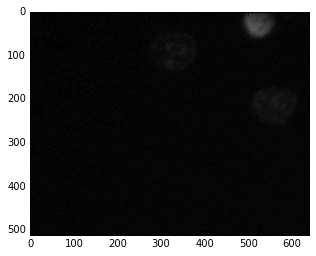

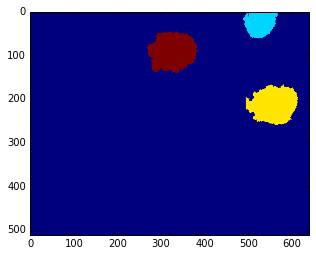

Mean gray value of whole image: 249.0083251953125
Median gray value of detected regions: 239.2493425172198
Set threshold to: 246.56857952578932
0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5
Processing 1 images
image                    shape: (256, 256, 3)         min:   -3.00000  max:   74.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -126.70000  max:  -29.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Median size: 153.0
Mean gray value of whole image: 250.54685974121094
Median gray value of detected regions: 215.2258064516129
Set threshold to: 241.71659641881143
Watershed kernel size: 2


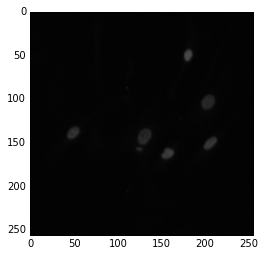

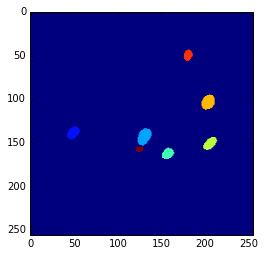

Mean gray value of whole image: 250.54685974121094
Median gray value of detected regions: 215.2258064516129
Set threshold to: 241.71659641881143
0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466
Processing 1 images
image                    shape: (512, 680, 3)         min:  -45.00000  max:  209.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -168.70000  max:  105.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  852.00000
Median size: 639.0
Mean gray value of whole image: 147.32095875459558
Median gray value of detected regions: 84.62653639924918
Set threshold to: 131.64735316575897
Watershed kernel size: 5


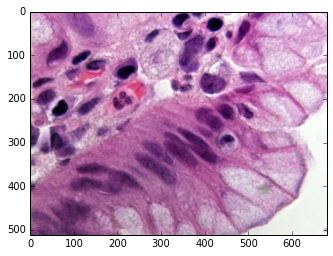

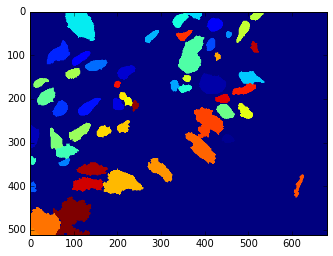

Mean gray value of whole image: 147.32095875459558
Median gray value of detected regions: 73.51963117732558
Set threshold to: 128.87062686027807
b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3
Processing 1 images
image                    shape: (524, 348, 3)         min:  -35.00000  max:  219.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -158.70000  max:  115.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  774.00000
Median size: 200.0
Mean gray value of whole image: 192.42842414670528
Median gray value of detected regions: 95.2884012539185
Set threshold to: 168.1434184235086
Watershed kernel size: 3


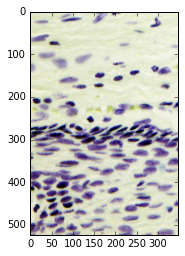

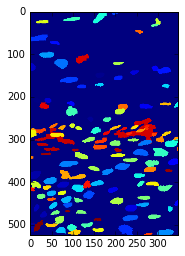

Mean gray value of whole image: 192.42842414670528
Median gray value of detected regions: 99.28379888268157
Set threshold to: 169.14226783069935
3c4c675825f7509877bc10497f498c9a2e3433bf922bd870914a2eb21a54fd26
Processing 1 images
image                    shape: (524, 348, 3)         min:  -34.00000  max:  220.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -157.70000  max:  116.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  774.00000
Median size: 207.0
Mean gray value of whole image: 201.68424256383258
Median gray value of detected regions: 112.07589285714286
Set threshold to: 179.28215513716015
Watershed kernel size: 3


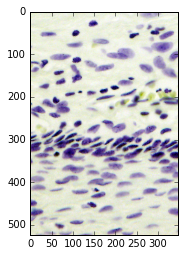

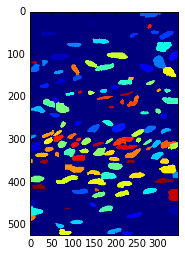

Mean gray value of whole image: 201.68424256383258
Median gray value of detected regions: 114.12027514666894
Set threshold to: 179.79325070954167
1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b
Processing 1 images
image                    shape: (512, 640, 3)         min:   -7.00000  max:   68.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -130.70000  max:  -35.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  832.00000
Median size: 6467.5
Mean gray value of whole image: 247.24602355957032
Median gray value of detected regions: 231.45756089902545
Set threshold to: 243.2989078944341
Watershed kernel size: 16


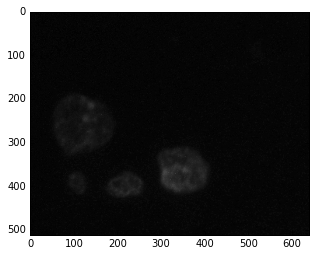

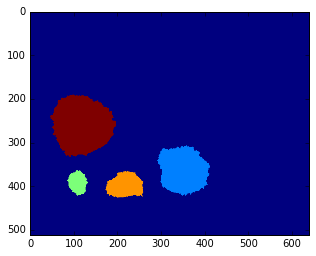

Mean gray value of whole image: 247.24602355957032
Median gray value of detected regions: 232.23566154211176
Set threshold to: 243.49343305520568
1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e5c1c4cc586bc69f81a
Processing 1 images
image                    shape: (519, 162, 3)         min:  -28.00000  max:  175.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  922.00000
Median size: 372.0
Mean gray value of whole image: 225.3880563286472
Median gray value of detected regions: 198.07895421415373
Set threshold to: 218.56078080002385
Watershed kernel size: 4


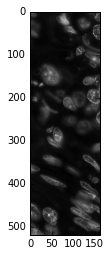

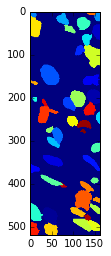

Mean gray value of whole image: 225.3880563286472
Median gray value of detected regions: 194.2856534090909
Set threshold to: 217.61245559875812
eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9c04884be8cca3da835
Processing 1 images
image                    shape: (519, 253, 3)         min:  -17.00000  max:  197.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  774.00000
Median size: 499.0
Mean gray value of whole image: 227.4207544152254
Median gray value of detected regions: 211.28103281853282
Set threshold to: 223.38582401605225
Watershed kernel size: 4


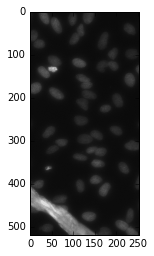

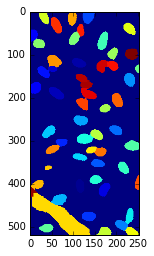

Mean gray value of whole image: 227.4207544152254
Median gray value of detected regions: 210.91987944102453
Set threshold to: 223.29553567167517
fe9adb627a6f45747c5a8223b671774791ededf9364f6544be487c540107fa4f
Processing 1 images
image                    shape: (256, 256, 3)         min:  -18.00000  max:  227.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -141.70000  max:  123.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Median size: 110.0
Mean gray value of whole image: 227.52964782714844
Median gray value of detected regions: 161.35218253968253
Set threshold to: 210.98528150528196
Watershed kernel size: 2


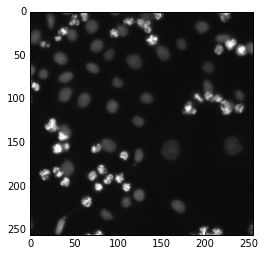

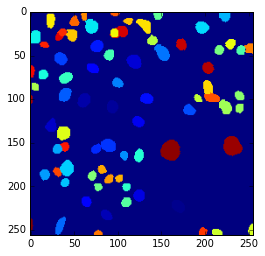

Mean gray value of whole image: 227.52964782714844
Median gray value of detected regions: 164.41666666666666
Set threshold to: 211.75140253702799
191b2b2205f2f5cc9da04702c5d422bc249faf8bca1107af792da63cccfba829
Processing 1 images
image                    shape: (256, 256, 3)         min:   -4.00000  max:  103.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -127.70000  max:   -0.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Median size: 184.0
Mean gray value of whole image: 250.53309631347656
Median gray value of detected regions: 218.6195652173913
Set threshold to: 242.55471353945524
Watershed kernel size: 3


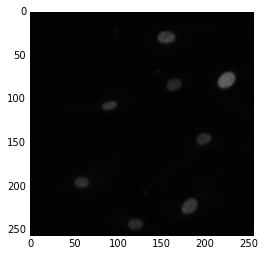

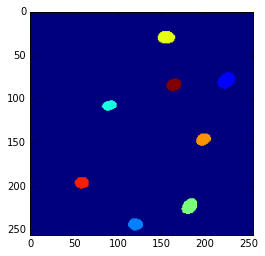

Mean gray value of whole image: 250.53309631347656
Median gray value of detected regions: 214.43747001439309
Set threshold to: 241.5091897387057
519dc0d672d1c295fc69b629af8721ccb1a1f136d1976685a68487e62547ffe0
Processing 1 images
image                    shape: (256, 256, 3)         min:   -3.00000  max:  116.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -126.70000  max:   12.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Median size: 158.0
Mean gray value of whole image: 250.36361694335938
Median gray value of detected regions: 216.4256709776109
Set threshold to: 241.87913045192226
Watershed kernel size: 3


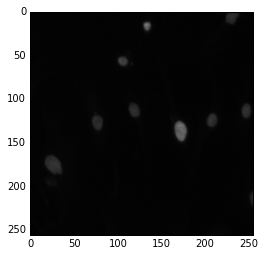

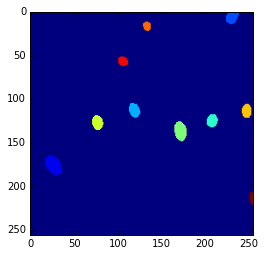

Mean gray value of whole image: 250.36361694335938
Median gray value of detected regions: 216.54491773720983
Set threshold to: 241.908942141822
648c8ffa496e1716017906d0bf135debfc93386ae86aa3d4adbda9a505985fd9
Processing 1 images
image                    shape: (256, 256, 3)         min:   -4.00000  max:  241.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -127.70000  max:  137.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Median size: 155.0
Mean gray value of whole image: 241.349365234375
Median gray value of detected regions: 173.2089552238806
Set threshold to: 224.3142627317514
Watershed kernel size: 2


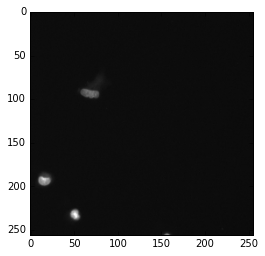

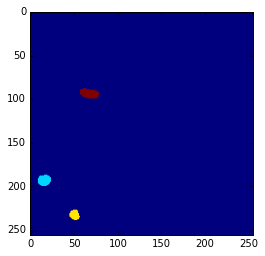

Mean gray value of whole image: 241.349365234375
Median gray value of detected regions: 131.17088607594937
Set threshold to: 213.8047454447686
f5effed21f671bbf4551ecebb7fe95f3be1cf09c16a60afe64d2f0b95be9d1eb
Processing 1 images
image                    shape: (512, 680, 3)         min:  -21.00000  max:  233.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -144.70000  max:  129.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  852.00000
Median size: 604.0
Mean gray value of whole image: 215.33087086397057
Median gray value of detected regions: 89.82554517133957
Set threshold to: 183.95453944081282
Watershed kernel size: 5


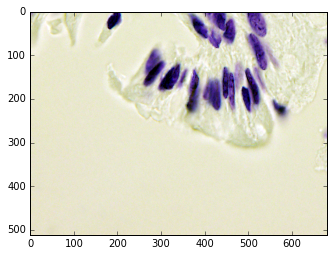

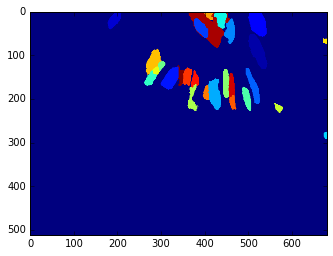

Mean gray value of whole image: 215.33087086397057
Median gray value of detected regions: 66.65301724137932
Set threshold to: 178.16140745832274
4be73d68f433869188fe5e7f09c7f681ed51003da6aa5d19ce368726d8e271ee
Processing 1 images
image                    shape: (256, 256, 3)         min:  -16.00000  max:  238.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -139.70000  max:  134.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Median size: 240.0
Mean gray value of whole image: 238.74102783203125
Median gray value of detected regions: 189.3753123915307
Set threshold to: 226.39959897190613
Watershed kernel size: 3


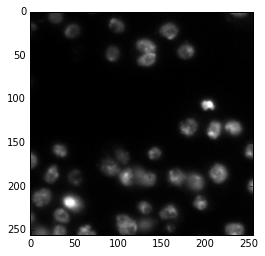

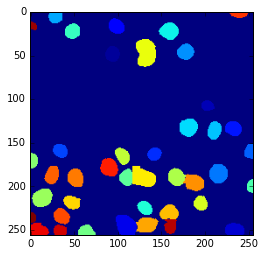

Mean gray value of whole image: 238.74102783203125
Median gray value of detected regions: 188.91168091168092
Set threshold to: 226.28369110194367
8922a6ac8fd0258ec27738ca101867169b20d90a60fc84f93df77acd5bf7c80b
Processing 1 images
image                    shape: (512, 640, 3)         min:   -7.00000  max:  178.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -130.70000  max:   74.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  832.00000
Median size: 1216.0
Mean gray value of whole image: 247.1165985107422
Median gray value of detected regions: 218.00688073394497
Set threshold to: 239.8391690665429
Watershed kernel size: 7


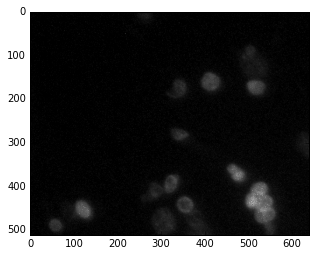

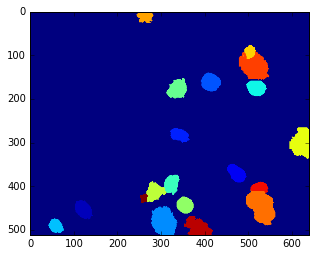

Mean gray value of whole image: 247.1165985107422
Median gray value of detected regions: 220.9247104247104
Set threshold to: 240.56862648923425
a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a2607e974e65e9cddba4f
Processing 1 images
image                    shape: (519, 253, 3)         min:  -11.00000  max:   80.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  142.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  774.00000
Median size: 480.5
Mean gray value of whole image: 234.1259338801435
Median gray value of detected regions: 213.04027556249363
Set threshold to: 228.85451930073103
Watershed kernel size: 4


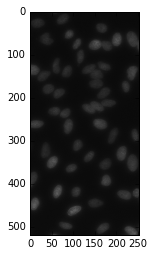

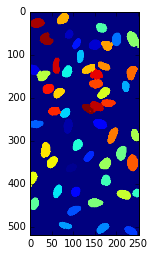

Mean gray value of whole image: 234.1259338801435
Median gray value of detected regions: 213.2641392202628
Set threshold to: 228.9104852151733
44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078
Processing 1 images
image                    shape: (512, 680, 3)         min:  -35.00000  max:  219.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -158.70000  max:  115.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  852.00000
Median size: 972.5
Mean gray value of whole image: 200.6195628446691
Median gray value of detected regions: 103.73057801536919
Set threshold to: 176.39731663734415
Watershed kernel size: 6


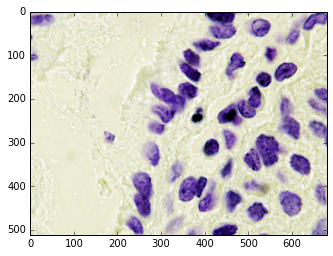

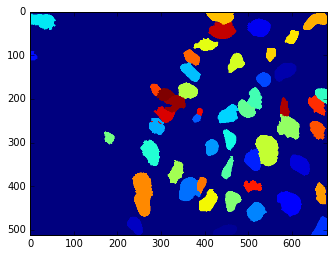

Mean gray value of whole image: 200.6195628446691
Median gray value of detected regions: 91.96898550724637
Set threshold to: 173.45691851031341
9f17aea854db13015d19b34cb2022cfdeda44133323fcd6bb3545f7b9404d8ab
Processing 1 images
image                    shape: (512, 680, 3)         min:  -30.00000  max:  224.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -153.70000  max:  120.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  852.00000
Median size: 604.0
Mean gray value of whole image: 209.4518123851103
Median gray value of detected regions: 123.31044776119403
Set threshold to: 187.91647122913122
Watershed kernel size: 5


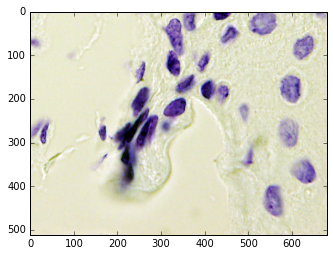

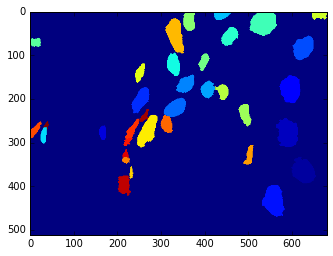

Mean gray value of whole image: 209.4518123851103
Median gray value of detected regions: 123.04972375690608
Set threshold to: 187.8512902280592
d8d4bf68a76e4e4c5f21de7ac613451f7115a04db686151e78b8ec0b6a22022b
Processing 1 images
image                    shape: (256, 256, 3)         min:   -4.00000  max:  179.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -127.70000  max:   75.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Median size: 69.5
Mean gray value of whole image: 242.2716064453125
Median gray value of detected regions: 163.4875
Set threshold to: 222.57557983398436
Watershed kernel size: 2


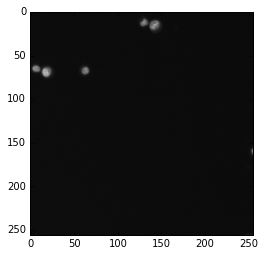

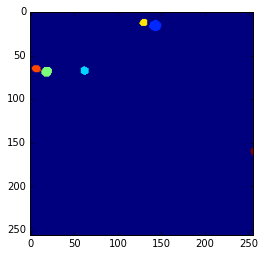

Mean gray value of whole image: 242.2716064453125
Median gray value of detected regions: 163.4875
Set threshold to: 222.57557983398436
1747f62148a919c8feb6d607faeebdf504b5e2ad42b6b1710b1189c37ebcdb2c
Processing 1 images
image                    shape: (512, 640, 3)         min:  -10.00000  max:  181.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -133.70000  max:   77.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  832.00000
Median size: 1087.5
Mean gray value of whole image: 244.73867492675782
Median gray value of detected regions: 217.39464721851215
Set threshold to: 237.9026679996964
Watershed kernel size: 7


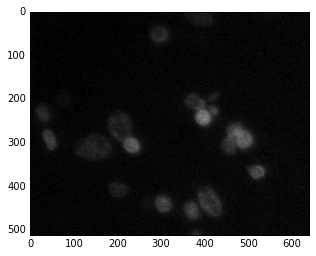

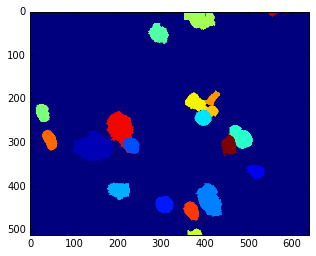

Mean gray value of whole image: 244.73867492675782
Median gray value of detected regions: 212.3383295712136
Set threshold to: 236.63858858787177
697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808
Processing 1 images
image                    shape: (256, 256, 3)         min:  -32.00000  max:  222.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -155.70000  max:  118.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Median size: 260.0
Mean gray value of whole image: 222.0625762939453
Median gray value of detected regions: 154.18283453732369
Set threshold to: 205.09264085478992
Watershed kernel size: 3


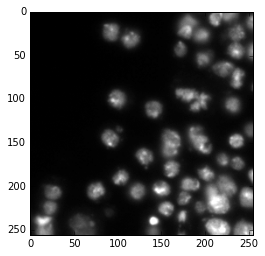

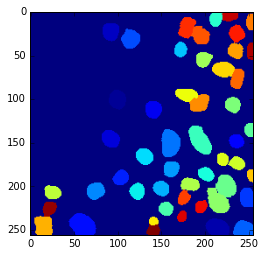

Mean gray value of whole image: 222.0625762939453
Median gray value of detected regions: 153.61646194641713
Set threshold to: 204.95104770706325
52b267e20519174e3ce1e1994b5d677804b16bc670aa5f6ffb6344a0fdf63fde
Processing 1 images
image                    shape: (260, 347, 3)         min:  -45.00000  max:  183.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -168.70000  max:   79.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  685.00000
Median size: 165.5
Mean gray value of whole image: 183.2585457769896
Median gray value of detected regions: 105.69292301900998
Set threshold to: 163.86714008749468
Watershed kernel size: 3


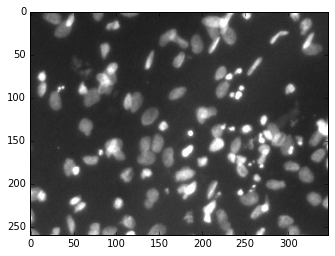

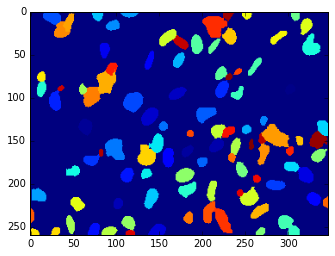

Mean gray value of whole image: 183.2585457769896
Median gray value of detected regions: 106.78573241939579
Set threshold to: 164.14034243759113
4727d94c6a57ed484270fdd8bbc6e3d5f2f15d5476794a4e37a40f2309a091e2
Processing 1 images
image                    shape: (256, 256, 3)         min:   -5.00000  max:  239.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -128.70000  max:  135.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Median size: 78.5
Mean gray value of whole image: 239.50961303710938
Median gray value of detected regions: 129.71211365902292
Set threshold to: 212.06023819258775
Watershed kernel size: 2


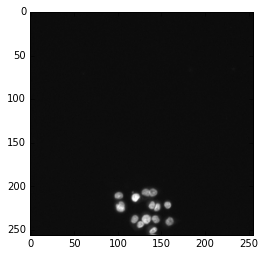

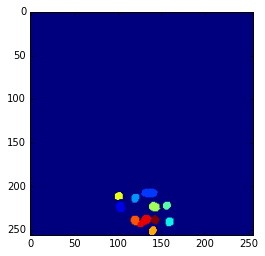

Mean gray value of whole image: 239.50961303710938
Median gray value of detected regions: 128.44117647058823
Set threshold to: 211.7425038954791
8b59819fbc92eefe45b1db95c0cc3a467ddcfc755684c7f2ba2f6ccb9ad740ab
Processing 1 images
image                    shape: (520, 696, 3)         min:  -15.00000  max:  211.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -138.70000  max:  107.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  860.00000
Median size: 912.5
Mean gray value of whole image: 229.99982869142352
Median gray value of detected regions: 149.4855576639258
Set threshold to: 209.87126093454907
Watershed kernel size: 6


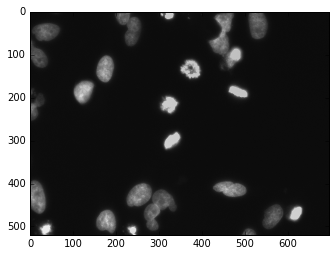

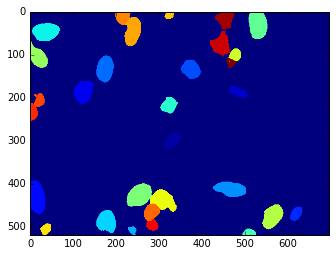

Mean gray value of whole image: 229.99982869142352
Median gray value of detected regions: 147.65076901027152
Set threshold to: 209.41256377113552
4f949bd8d914bbfa06f40d6a0e2b5b75c38bf53dbcbafc48c97f105bee4f8fac
Processing 1 images
image                    shape: (390, 239, 3)         min:  -17.00000  max:   63.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  143.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  721.00000
Median size: 133.5
Mean gray value of whole image: 237.79578371419376
Median gray value of detected regions: 220.6956237882325
Set threshold to: 233.52074373270347
Watershed kernel size: 2


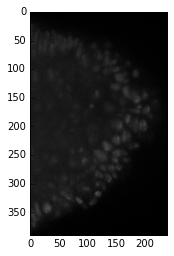

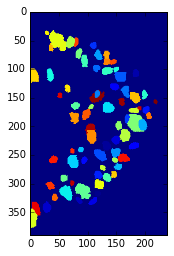

Mean gray value of whole image: 237.79578371419376
Median gray value of detected regions: 220.6474820143885
Set threshold to: 233.50870828924246
fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e1751a9d412a14ab5e3
Processing 1 images
image                    shape: (256, 256, 3)         min:   -9.00000  max:  236.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -132.70000  max:  132.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Median size: 92.0
Mean gray value of whole image: 236.5864715576172
Median gray value of detected regions: 137.4693146724489
Set threshold to: 211.80718233632513
Watershed kernel size: 2


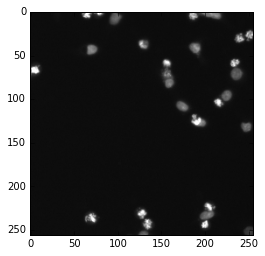

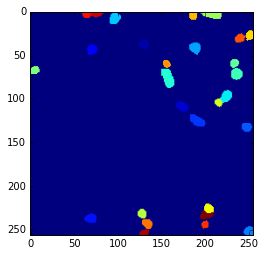

Mean gray value of whole image: 236.5864715576172
Median gray value of detected regions: 139.30961115187088
Set threshold to: 212.2672564561806
336d3e4105766f8ad328a7ee9571e743f376f8cbcf6a969ca7e353fe3235c523
Processing 1 images
image                    shape: (519, 253, 3)         min:  -28.00000  max:  171.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  774.00000
Median size: 466.0
Mean gray value of whole image: 215.03392812264389
Median gray value of detected regions: 199.74358974358975
Set threshold to: 211.21134352788036
Watershed kernel size: 4


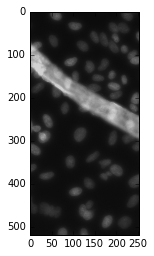

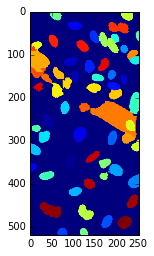

Mean gray value of whole image: 215.03392812264389
Median gray value of detected regions: 195.7883435582822
Set threshold to: 210.2225319815535
38f5cfb55fc8b048e82a5c895b25fefae7a70c71ab9990c535d1030637bf6a1f
Processing 1 images
image                    shape: (256, 256, 3)         min:   -3.00000  max:   97.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -126.70000  max:   -6.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Median size: 108.5
Mean gray value of whole image: 251.17266845703125
Median gray value of detected regions: 205.86129991503822
Set threshold to: 239.844826321533
Watershed kernel size: 2


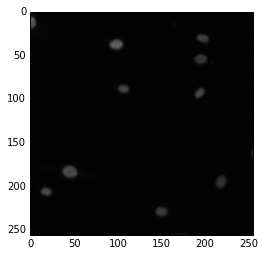

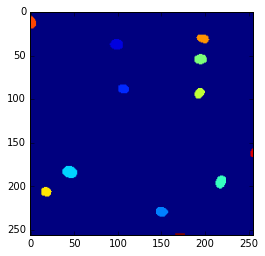

Mean gray value of whole image: 251.17266845703125
Median gray value of detected regions: 205.86129991503822
Set threshold to: 239.844826321533
0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732
Processing 1 images
image                    shape: (256, 256, 3)         min:  -22.00000  max:  232.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -145.70000  max:  128.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Median size: 287.0
Mean gray value of whole image: 232.12232971191406
Median gray value of detected regions: 171.90131578947367
Set threshold to: 217.06707623130396
Watershed kernel size: 3


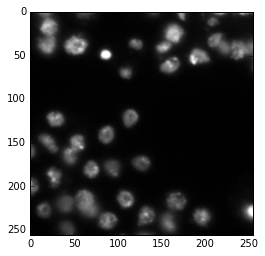

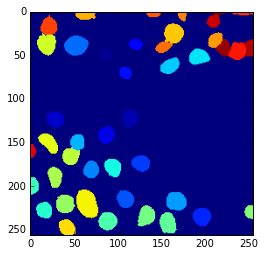

Mean gray value of whole image: 232.12232971191406
Median gray value of detected regions: 171.82781456953643
Set threshold to: 217.04870092631967
ade080c6618cbbb0a25680cf847f312b5e19b22bfe1cafec0436987ebe5b1e7e
Processing 1 images
image                    shape: (520, 696, 3)         min:  -10.00000  max:  203.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -133.70000  max:   99.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  860.00000
Median size: 937.0
Mean gray value of whole image: 233.1184046198055
Median gray value of detected regions: 159.4931506849315
Set threshold to: 214.712091136087
Watershed kernel size: 6


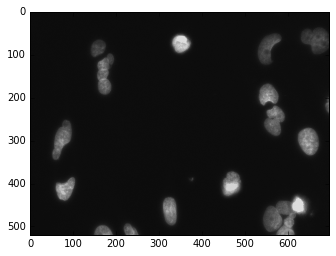

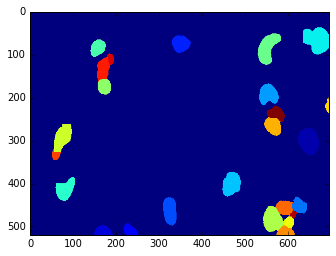

Mean gray value of whole image: 233.1184046198055
Median gray value of detected regions: 158.64533053515214
Set threshold to: 214.50013609864214
472b1c5ff988dadc209faea92499bc07f305208dbda29d16262b3d543ac91c71
Processing 1 images
image                    shape: (512, 680, 3)         min:  -77.00000  max:  177.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -200.70000  max:   73.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  852.00000
Median size: 844.0
Mean gray value of whole image: 140.15191578584557
Median gray value of detected regions: 72.75471698113208
Set threshold to: 123.30261608466719
Watershed kernel size: 6


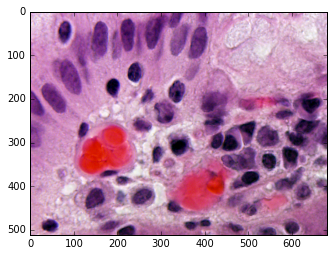

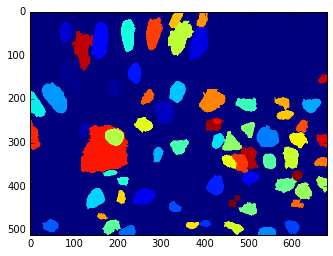

Mean gray value of whole image: 140.15191578584557
Median gray value of detected regions: 75.20847343644922
Set threshold to: 123.91605519849648
43a71aeb641faa18742cb826772a8566c6c947d7050f9ab15459de6cc2b3b6af
Processing 1 images
image                    shape: (260, 347, 3)         min:  -59.00000  max:  193.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -182.70000  max:   89.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  685.00000
Median size: 148.0
Mean gray value of whole image: 193.35494347151408
Median gray value of detected regions: 108.46815476190477
Set threshold to: 172.13324629411176
Watershed kernel size: 2


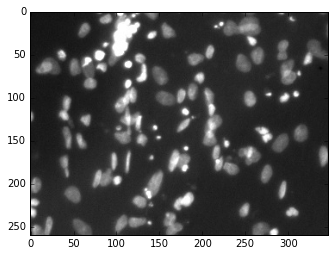

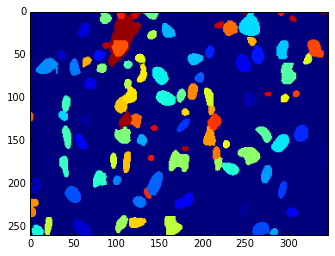

Mean gray value of whole image: 193.35494347151408
Median gray value of detected regions: 109.67783229692967
Set threshold to: 172.43566567786797
ca20076870e8fb604e61802605a9ac45419c82dd3e23404c56c4869f9502a5ef
Processing 1 images
image                    shape: (519, 161, 3)         min:  -30.00000  max:  224.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  924.00000
Median size: 318.0
Mean gray value of whole image: 224.6876697902081
Median gray value of detected regions: 190.28173913043477
Set threshold to: 216.08618712526476
Watershed kernel size: 4


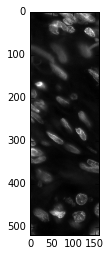

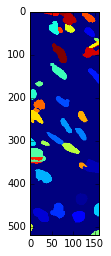

Mean gray value of whole image: 224.6876697902081
Median gray value of detected regions: 181.92001380262252
Set threshold to: 213.9957557933117
0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac
Processing 1 images
image                    shape: (519, 253, 3)         min:  -21.00000  max:  209.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  774.00000
Median size: 502.0
Mean gray value of whole image: 222.4386666362037
Median gray value of detected regions: 201.05882352941177
Set threshold to: 217.0937058595057
Watershed kernel size: 4


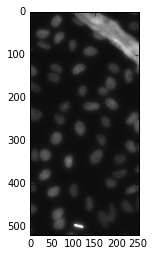

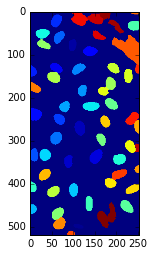

Mean gray value of whole image: 222.4386666362037
Median gray value of detected regions: 200.54397834912044
Set threshold to: 216.96499456443286
c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf7a082a0ace86d609eb
Processing 1 images
image                    shape: (524, 348, 3)         min:  -30.00000  max:  224.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -153.70000  max:  120.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  774.00000
Median size: 154.0
Mean gray value of whole image: 216.5824284899535
Median gray value of detected regions: 94.12913907284768
Set threshold to: 185.96910613567704
Watershed kernel size: 2


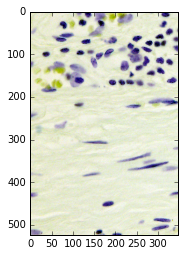

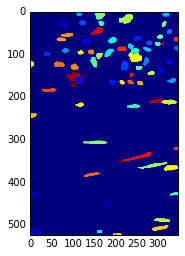

Mean gray value of whole image: 216.5824284899535
Median gray value of detected regions: 93.0926314626602
Set threshold to: 185.70997923313016
df40099c6306ca1f47fcc8a62e2fa39486d4e223177afdc51b2ad189691802d8
Processing 1 images
image                    shape: (260, 347, 3)         min:  -50.00000  max:  204.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -173.70000  max:  100.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  685.00000
Median size: 179.5
Mean gray value of whole image: 204.41086233651075
Median gray value of detected regions: 132.57159208388717
Set threshold to: 186.45104477335485
Watershed kernel size: 3


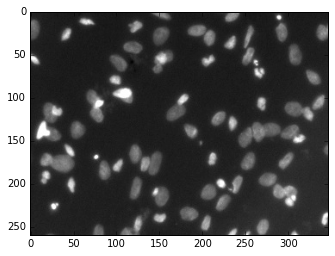

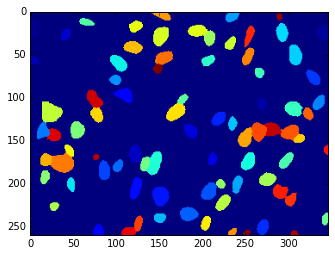

Mean gray value of whole image: 204.41086233651075
Median gray value of detected regions: 134.98448579331153
Set threshold to: 187.05426820071096
d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633fdf582447c686018896
Processing 1 images
image                    shape: (520, 348, 3)         min:  -27.00000  max:  173.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -150.70000  max:   69.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  772.00000
Median size: 254.0
Mean gray value of whole image: 227.61332891246684
Median gray value of detected regions: 194.17490494296578
Set threshold to: 219.25372292009158
Watershed kernel size: 3


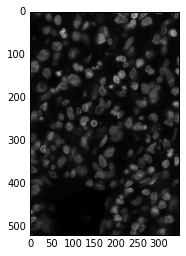

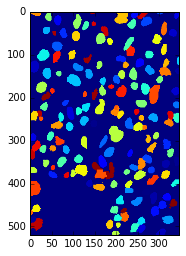

Mean gray value of whole image: 227.61332891246684
Median gray value of detected regions: 194.284064665127
Set threshold to: 219.2810128506319
d616d323a9eeb9da1b66f8d5df671d63c092c9919cb2c0b223e29c63257c944d
Processing 1 images
image                    shape: (519, 162, 3)         min:  -46.00000  max:  205.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  922.00000
Median size: 305.0
Mean gray value of whole image: 205.19912462237446
Median gray value of detected regions: 164.8619377405232
Set threshold to: 195.11482790191164
Watershed kernel size: 3


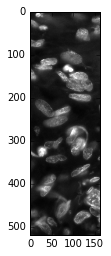

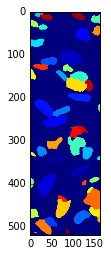

Mean gray value of whole image: 205.19912462237446
Median gray value of detected regions: 151.9543650793651
Set threshold to: 191.8879347366221
1cdbfee1951356e7b0a215073828695fe1ead5f8b1add119b6645d2fdc8d844e
Processing 1 images
image                    shape: (512, 640, 3)         min:   -3.00000  max:  122.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -126.70000  max:   18.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  832.00000
Median size: 1216.0
Mean gray value of whole image: 251.34241943359376
Median gray value of detected regions: 229.85398680764382
Set threshold to: 245.9703112771063
Watershed kernel size: 7


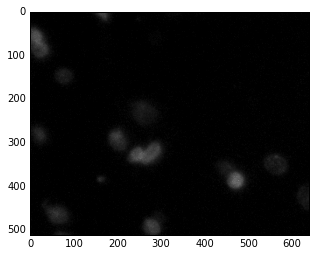

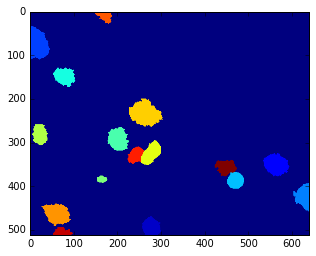

Mean gray value of whole image: 251.34241943359376
Median gray value of detected regions: 229.67024116056905
Set threshold to: 245.9243748653376
505bc0a3928d8aef5ce441c5a611fdd32e1e8eccdc15cc3a52b88030acb50f81
Processing 1 images
image                    shape: (512, 640, 3)         min:   -7.00000  max:  101.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -130.70000  max:   -2.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  832.00000
Median size: 2605.5
Mean gray value of whole image: 247.08382568359374
Median gray value of detected regions: 228.1684221909123
Set threshold to: 242.35497481042339
Watershed kernel size: 10


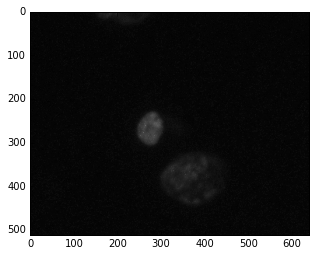

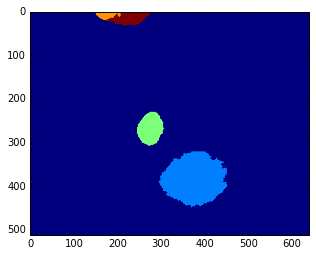

Mean gray value of whole image: 247.08382568359374
Median gray value of detected regions: 228.86630095874324
Set threshold to: 242.52944450238112
7f4cbe0b36b5d09466476a7d4e01f4f976c67872d549f4ff47b3e1e3a2b403af
Processing 1 images
image                    shape: (256, 256, 3)         min:  -17.00000  max:  227.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -140.70000  max:  123.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Median size: 296.0
Mean gray value of whole image: 237.7348175048828
Median gray value of detected regions: 167.40983606557376
Set threshold to: 220.15357214505553
Watershed kernel size: 3


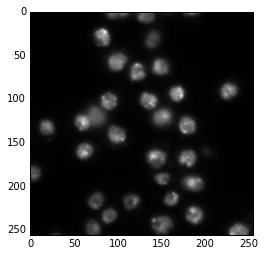

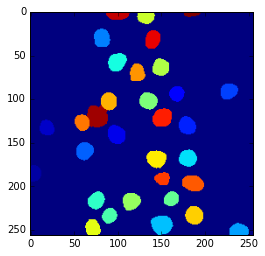

Mean gray value of whole image: 237.7348175048828
Median gray value of detected regions: 165.70937080661997
Set threshold to: 219.7284558303171
a984e7fb886aa02e29d112766d3ce26a4f78eac540ce7bbdbd42af2761928f6d
Processing 1 images
image                    shape: (519, 161, 3)         min:  -52.00000  max:  197.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  924.00000
Median size: 400.5
Mean gray value of whole image: 197.74396534185425
Median gray value of detected regions: 156.28347173245365
Set threshold to: 187.3788419395041
Watershed kernel size: 4


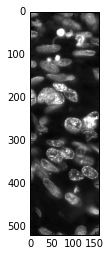

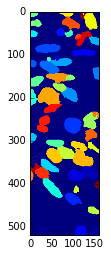

Mean gray value of whole image: 197.74396534185425
Median gray value of detected regions: 151.242261818533
Set threshold to: 186.11853946102394
7bdb668e6127b7eafc837a883f0648002bd063c736f55a4f673e787250a3fb04
Processing 1 images
image                    shape: (512, 640, 3)         min:  -12.00000  max:  164.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -135.70000  max:   60.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  832.00000
Median size: 1020.0
Mean gray value of whole image: 242.36052551269532
Median gray value of detected regions: 203.73945683141858
Set threshold to: 232.70525834237614
Watershed kernel size: 6


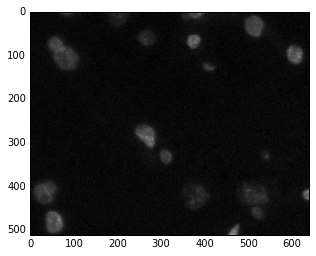

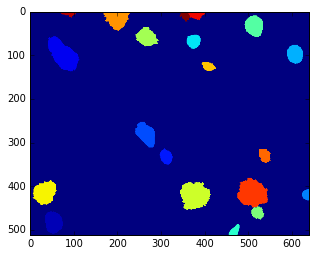

Mean gray value of whole image: 242.36052551269532
Median gray value of detected regions: 204.7070500484087
Set threshold to: 232.94715664662368
295682d9eb5acb5c1976a460c085734bfaf38482b0a3f02591c2bfdcd4128549
Processing 1 images
image                    shape: (256, 256, 3)         min:   -5.00000  max:  239.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -128.70000  max:  135.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Median size: 145.0
Mean gray value of whole image: 239.7753448486328
Median gray value of detected regions: 149.979020979021
Set threshold to: 217.32626388122986
Watershed kernel size: 2


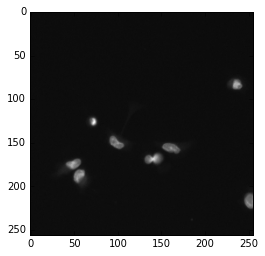

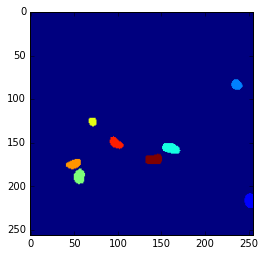

Mean gray value of whole image: 239.7753448486328
Median gray value of detected regions: 149.1050246305419
Set threshold to: 217.1077647941101
ab298b962a63e4be9582513aaa84a5e270adba5fd2b16a50e59540524f63c3b8
Processing 1 images
image                    shape: (256, 256, 3)         min:   -3.00000  max:   85.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -126.70000  max:  -18.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Median size: 116.0
Mean gray value of whole image: 251.506103515625
Median gray value of detected regions: 201.55734425604876
Set threshold to: 239.01891370073093
Watershed kernel size: 2


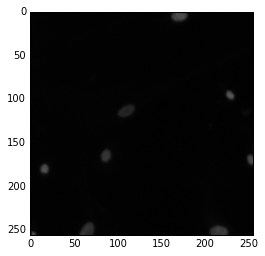

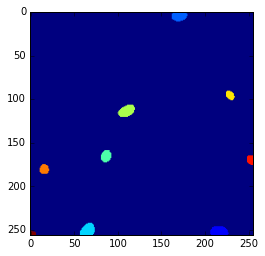

Mean gray value of whole image: 251.506103515625
Median gray value of detected regions: 199.9655172413793
Set threshold to: 238.62095694706358
699f2992cd71e2e28cf45f81347ff22e76b37541ce88087742884cd0e9aadc68
Processing 1 images
image                    shape: (260, 347, 3)         min:  -43.00000  max:  183.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -166.70000  max:   79.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  685.00000
Median size: 148.5
Mean gray value of whole image: 183.316592773221
Median gray value of detected regions: 97.32329683698296
Set threshold to: 161.8182687891615
Watershed kernel size: 2


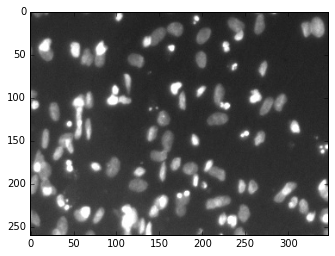

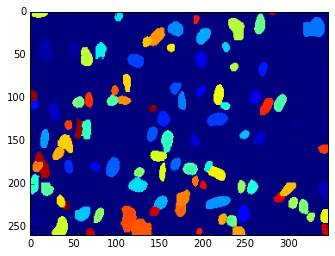

Mean gray value of whole image: 183.316592773221
Median gray value of detected regions: 97.67464539007092
Set threshold to: 161.9061059274335
51c70bb8a299943b27f8b354571272692d8f2705036a1a9562156c76da5f025b
Processing 1 images
image                    shape: (256, 256, 3)         min:   -4.00000  max:  241.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -127.70000  max:  137.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Median size: 57.0
Mean gray value of whole image: 241.59881591796875
Median gray value of detected regions: 126.81481481481481
Set threshold to: 212.90281564218026
Watershed kernel size: 2


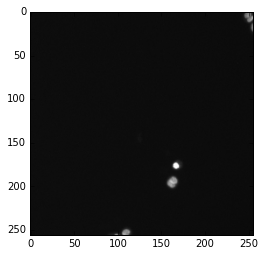

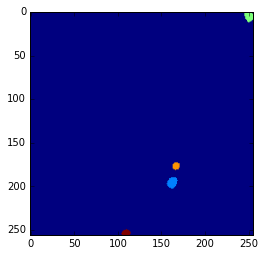

Mean gray value of whole image: 241.59881591796875
Median gray value of detected regions: 125.72890442890443
Set threshold to: 212.63133804570268
912a679e4b9b1d1a75170254fd675b8c24b664d80ad7ea7e460241a23535a406
Processing 1 images
image                    shape: (256, 256, 3)         min:  -21.00000  max:  223.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -144.70000  max:  119.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Median size: 128.0
Mean gray value of whole image: 223.90687561035156
Median gray value of detected regions: 159.97333333333333
Set threshold to: 207.923490041097
Watershed kernel size: 2


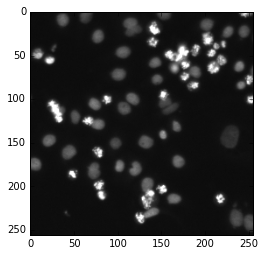

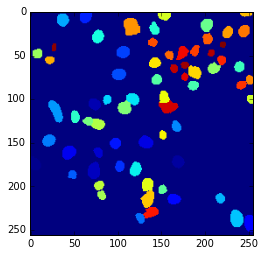

Mean gray value of whole image: 223.90687561035156
Median gray value of detected regions: 158.88135593220338
Set threshold to: 207.65049569081452
0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925
Processing 1 images
image                    shape: (256, 256, 3)         min:   -4.00000  max:  241.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -127.70000  max:  137.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Median size: 131.5
Mean gray value of whole image: 241.4495849609375
Median gray value of detected regions: 179.41189883913765
Set threshold to: 225.94016343048753
Watershed kernel size: 2


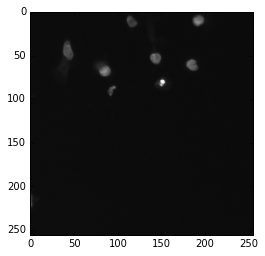

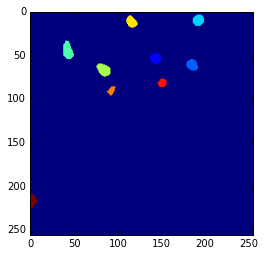

Mean gray value of whole image: 241.4495849609375
Median gray value of detected regions: 171.7674418604651
Set threshold to: 224.02904918581942
78a981bd27ba0c65a9169548665a17bda9f49050d0d3893a6567d1eb92cd003d
Processing 1 images
image                    shape: (520, 348, 3)         min:  -27.00000  max:  155.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -150.70000  max:   51.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  772.00000
Median size: 268.5
Mean gray value of whole image: 224.81196949602122
Median gray value of detected regions: 199.16048684103572
Set threshold to: 218.39909883227483
Watershed kernel size: 3


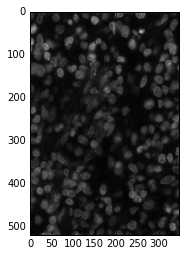

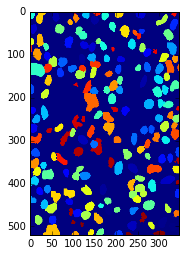

Mean gray value of whole image: 224.81196949602122
Median gray value of detected regions: 201.4178066257212
Set threshold to: 218.9634287784462
5cee644e5ffbef1ba021c7f389b33bafd3b1841f04d3edd7922d5084c2c4e0c7
Processing 1 images
image                    shape: (512, 640, 3)         min:   -8.00000  max:  143.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -131.70000  max:   39.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  832.00000
Median size: 896.0
Mean gray value of whole image: 245.4437255859375
Median gray value of detected regions: 217.2990158970477
Set threshold to: 238.40754816371503
Watershed kernel size: 6


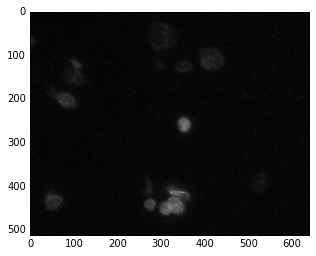

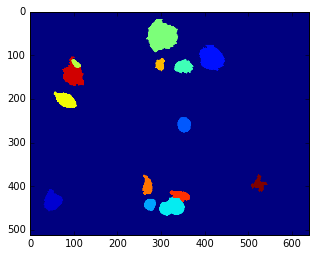

Mean gray value of whole image: 245.4437255859375
Median gray value of detected regions: 223.4695632198319
Set threshold to: 239.9501849944111
53df5150ee56253fe5bc91a9230d377bb21f1300f443ba45a758bcb01a15c0e4
Processing 1 images
image                    shape: (256, 256, 3)         min:   -4.00000  max:   87.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -127.70000  max:  -16.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Median size: 139.0
Mean gray value of whole image: 249.93797302246094
Median gray value of detected regions: 193.7340425531915
Set threshold to: 235.8869904051436
Watershed kernel size: 2


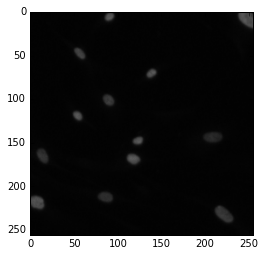

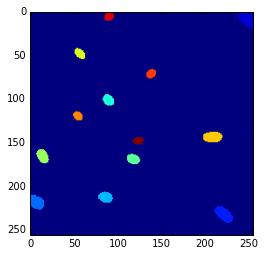

Mean gray value of whole image: 249.93797302246094
Median gray value of detected regions: 193.7340425531915
Set threshold to: 235.8869904051436
17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff
Processing 1 images
image                    shape: (512, 680, 3)         min:  -49.00000  max:  205.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -172.70000  max:  101.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  852.00000
Median size: 453.5
Mean gray value of whole image: 176.8101505055147
Median gray value of detected regions: 117.85121725254248
Set threshold to: 162.07041719227166
Watershed kernel size: 4


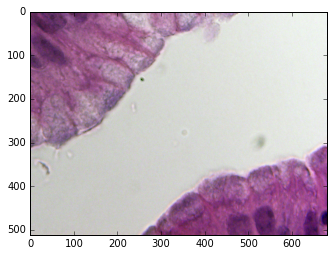

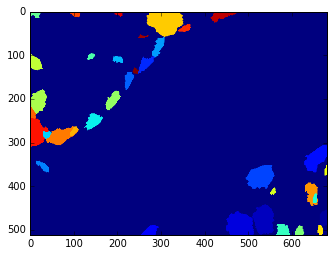

Mean gray value of whole image: 176.8101505055147
Median gray value of detected regions: 108.80099200063361
Set threshold to: 159.80786087929445
1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1
Processing 1 images
image                    shape: (524, 348, 3)         min:  -26.00000  max:  228.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -149.70000  max:  124.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  774.00000
Median size: 168.0
Mean gray value of whole image: 220.6134125208388
Median gray value of detected regions: 103.55906385281385
Set threshold to: 191.34982535383259
Watershed kernel size: 3


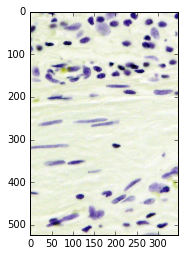

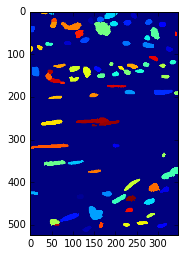

Mean gray value of whole image: 220.6134125208388
Median gray value of detected regions: 106.3420425386326
Set threshold to: 192.04557002528725
31f1fbe85b8899258ea5bcf5f93f7ac8238660c386aeab40649c715bd2e38a0a
Processing 1 images
image                    shape: (256, 256, 3)         min:   -5.00000  max:  239.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -128.70000  max:  135.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Median size: 137.0
Mean gray value of whole image: 239.8225860595703
Median gray value of detected regions: 133.97142857142856
Set threshold to: 213.35979668753487
Watershed kernel size: 2


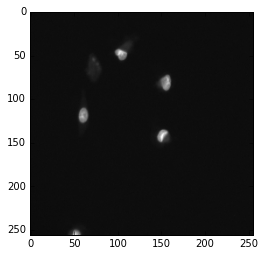

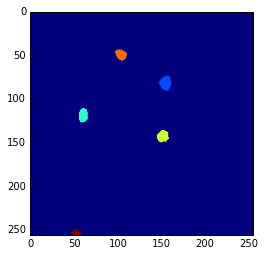

Mean gray value of whole image: 239.8225860595703
Median gray value of detected regions: 128.06428571428572
Set threshold to: 211.88301097324916
da6c593410340b19bb212b9f6d274f95b08c0fc8f2570cd66bc5ed42c560acab
Processing 1 images
image                    shape: (512, 680, 3)         min:  -39.00000  max:  215.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -162.70000  max:  111.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  852.00000
Median size: 675.5
Mean gray value of whole image: 195.84313246783088
Median gray value of detected regions: 85.36125886524823
Set threshold to: 168.22266406718524
Watershed kernel size: 5


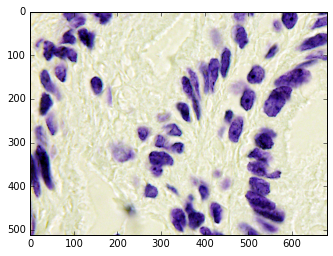

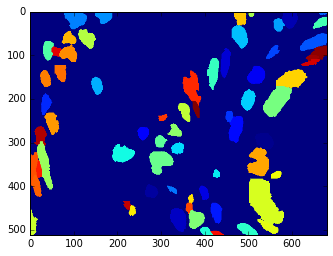

Mean gray value of whole image: 195.84313246783088
Median gray value of detected regions: 87.10510510510511
Set threshold to: 168.65862562714943
bdc789019cee8ddfae20d5f769299993b4b330b2d38d1218646cf89e77fbbd4d
Processing 1 images
image                    shape: (520, 696, 3)         min:  -11.00000  max:  207.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -134.70000  max:  103.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  860.00000
Median size: 1674.0
Mean gray value of whole image: 232.51055481874448
Median gray value of detected regions: 172.7480120450516
Set threshold to: 217.56991912532126
Watershed kernel size: 8


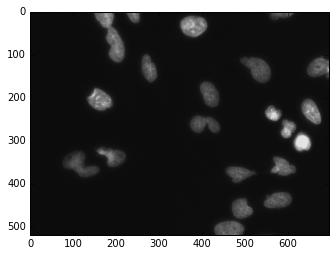

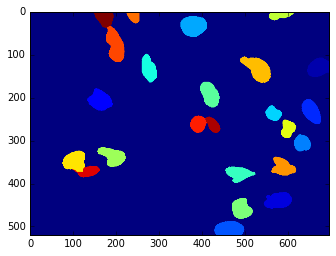

Mean gray value of whole image: 232.51055481874448
Median gray value of detected regions: 173.7075610829848
Set threshold to: 217.80980638480457
f0d0ab13ff53adc3c4d57e95a5f83d80b06f2cbc0bf002b52cf7b496612e0ce4
Processing 1 images
image                    shape: (520, 696, 3)         min:   -8.00000  max:  202.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -131.70000  max:   98.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  860.00000
Median size: 586.0
Mean gray value of whole image: 235.82005691865606
Median gray value of detected regions: 176.82754182754184
Set threshold to: 221.0719281458775
Watershed kernel size: 5


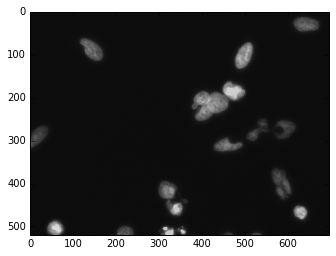

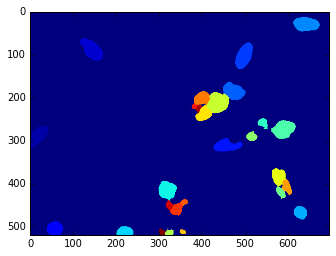

Mean gray value of whole image: 235.82005691865606
Median gray value of detected regions: 177.95437731196054
Set threshold to: 221.3536370169822
550450e4bff4036fd671decdc5d42fec23578198d6a2fd79179c4368b9d6da18
Processing 1 images
image                    shape: (520, 348, 3)         min:  -44.00000  max:  207.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -167.70000  max:  103.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  772.00000
Median size: 297.0
Mean gray value of whole image: 207.50964854111405
Median gray value of detected regions: 165.20154862826246
Set threshold to: 196.93262356290114
Watershed kernel size: 3


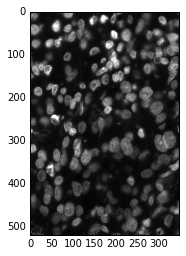

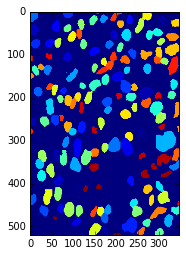

Mean gray value of whole image: 207.50964854111405
Median gray value of detected regions: 162.47061875586468
Set threshold to: 196.24989109480168
432f367a4c5b5674de2e2977744d10289a064e5704b21af6607b4975be47c580
Processing 1 images
image                    shape: (520, 348, 3)         min:  -46.00000  max:  203.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -169.70000  max:   99.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  772.00000
Median size: 275.0
Mean gray value of whole image: 203.7336759504863
Median gray value of detected regions: 160.17028985507247
Set threshold to: 192.84282942663285
Watershed kernel size: 3


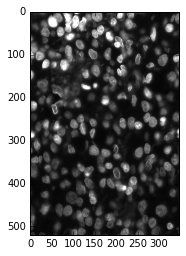

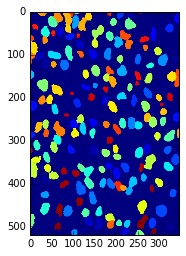

Mean gray value of whole image: 203.7336759504863
Median gray value of detected regions: 159.20398009950247
Set threshold to: 192.60125198774034
e17b7aedd251a016c01ef9158e6e4aa940d9f1b35942d86028dc1222192a9258
Processing 1 images
image                    shape: (256, 256, 3)         min:   -3.00000  max:   77.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -126.70000  max:  -26.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Median size: 175.0
Mean gray value of whole image: 250.65567016601562
Median gray value of detected regions: 212.32704254518072
Set threshold to: 241.0735132608069
Watershed kernel size: 3


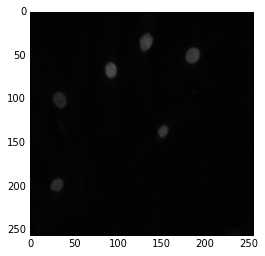

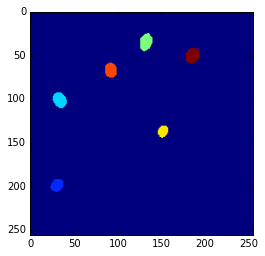

Mean gray value of whole image: 250.65567016601562
Median gray value of detected regions: 206.12648168103448
Set threshold to: 239.52337304477032
259b35151d4a7a5ffdd7ab7f171b142db8cfe40beeee67277fac6adca4d042c4
Processing 1 images
image                    shape: (512, 680, 3)         min:  -62.00000  max:  192.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -185.70000  max:   88.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  852.00000
Median size: 720.0
Mean gray value of whole image: 150.62937729779412
Median gray value of detected regions: 104.2892561983471
Set threshold to: 139.04434702293236
Watershed kernel size: 5


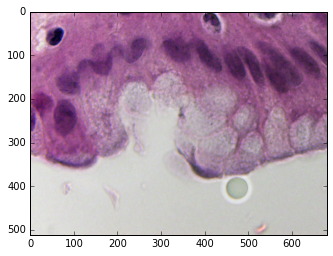

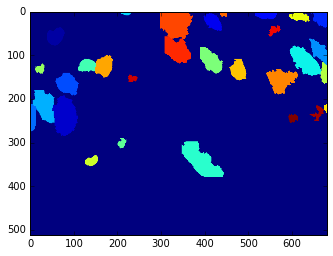

Mean gray value of whole image: 150.62937729779412
Median gray value of detected regions: 83.29589076693631
Set threshold to: 133.79600566507966
1ef68e93964c2d9230100c1347c328f6385a7bc027879dc3d4c055e6fe80cb3c
Processing 1 images
image                    shape: (256, 256, 3)         min:  -10.00000  max:  234.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -133.70000  max:  130.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Median size: 119.0
Mean gray value of whole image: 234.0468292236328
Median gray value of detected regions: 126.67149758454106
Set threshold to: 207.20299631385987
Watershed kernel size: 2


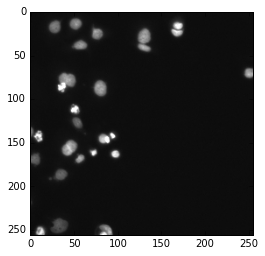

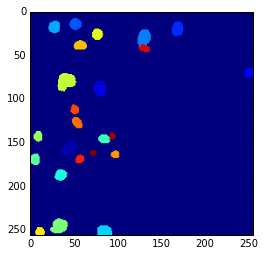

Mean gray value of whole image: 234.0468292236328
Median gray value of detected regions: 127.35279424681599
Set threshold to: 207.3733204794286
dab46d798d29aff2e99c23f47ed3064f5cafb1644629b015c95a2dd2ee593bb4
Processing 1 images
image                    shape: (256, 256, 3)         min:   -3.00000  max:   90.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -126.70000  max:  -13.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Median size: 154.0
Mean gray value of whole image: 250.2691650390625
Median gray value of detected regions: 200.34313725490196
Set threshold to: 237.78765809302237
Watershed kernel size: 2


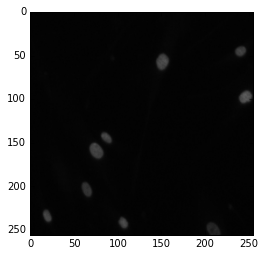

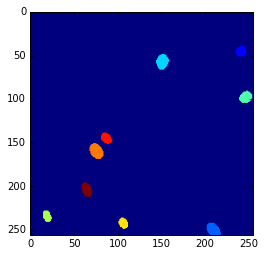

Mean gray value of whole image: 250.2691650390625
Median gray value of detected regions: 200.34313725490196
Set threshold to: 237.78765809302237
0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6
Processing 1 images
image                    shape: (256, 256, 3)         min:   -7.00000  max:  237.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -130.70000  max:  133.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Median size: 105.0
Mean gray value of whole image: 237.88485717773438
Median gray value of detected regions: 102.83009404388716
Set threshold to: 204.12116639427256
Watershed kernel size: 2


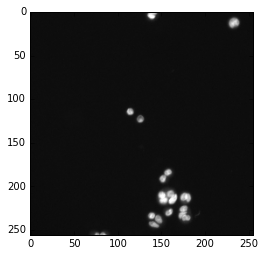

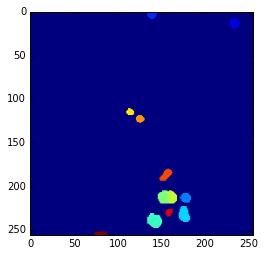

Mean gray value of whole image: 237.88485717773438
Median gray value of detected regions: 103.32327586206897
Set threshold to: 204.24446184881802


In [61]:
with open("submission_mask_RCNN_v16.csv", "w") as myfile:
    myfile.write("ImageId,EncodedPixels\n")
    for i, image in enumerate(test_images):
        print(test_dirs[i])
        
        # Preprocessing, color deconvolution
        HEStaining = False
        if not np.all(image[:,:,0]==image[:,:,1]):
            HEStaining = True
            _, He, _, _ = channelDeconvolution(image, stainingType = "HEB", plotImage = False)
            # 99-2 percentile normalization:
            He = (He - np.percentile(He, 2))/(np.percentile(He, 99) - np.percentile(He, 2))
            np.clip(He, 0, 1, out = He)
            image = np.transpose(np.array(np.array([He,He,He])*255, dtype=np.uint8), (1,2,0))
            
        # Normalization
        imageNorm = np.array(image, dtype=float)
        for j in range(3):
            imageNorm[:, :, j] = imageNorm[:, :, j] - np.mean(imageNorm[:, :, j])
        imageNorm = np.array(imageNorm, dtype=int)
        
        results = model.detect([imageNorm], verbose=1)
        masks = results[0]['masks']
        
        # Remove the mask that overlaps tooooooo much with previously detected region
        occlusion = np.ones(np.shape(masks)[0:2])
        toKeep = []
        for j in range(masks.shape[2]):
            # Remove the mask with tooooo much overlapping with previously detected region
            originalArea = np.sum(masks[:,:,j])
            masks[:, :, j] = masks[:, :, j] * occlusion        
            newArea = np.sum(masks[:,:,j])
            if newArea > 0 and newArea/originalArea > 0.6:
                toKeep.append(True)
                occlusion = np.logical_and(occlusion, np.logical_not(masks[:, :, j]))
            else:
                toKeep.append(False)
        masks = masks[:,:,toKeep]
        
        # Remove the mask with area toooooo large or toooooo small
        areas = []
        for j in range(masks.shape[2]):
            areas.append(np.sum(masks[:,:,j]))
        masks = masks[:,:,(areas < np.median(areas)*10) & (areas > np.median(areas)/10)]
        areas = []
        for j in range(masks.shape[2]):
            areas.append(np.sum(masks[:,:,j]))
        medianArea = np.median(areas)
        print("Median size: {}".format(np.median(medianArea)))
        
        # Test if there is any false positives; suppose in RGB-Gray HE staining, lower grey value is more likely to be true
        if HEStaining:
            grayImage = cv2.cvtColor(test_images[i], cv2.COLOR_RGB2GRAY)
        else:
            grayImage = 255 - image # Background is 255, cell is 0
        grayValues = []
        for j in range(masks.shape[2]):
            prop = skimage.measure.regionprops(masks[:,:,j])[0]
            grayValue = grayImage[prop['coords'][:, 0], prop['coords'][:, 1]]
            grayValues.append(np.mean(grayValue))
        print("Mean gray value of whole image: {}".format(np.mean(grayImage)))
        print("Median gray value of detected regions: {}".format(np.median(grayValues)))
        if (np.mean(grayImage) > np.median(grayValues)):
            # When signal is actually darker
            threshold = (np.mean(grayImage)*3 + np.median(grayValues))/4
            # threshold = np.mean(grayImage)
            print("Set threshold to: {}".format(threshold))
            masks = masks[:,:,grayValues<threshold]
        else:
            print("Nuclei is lighter.")
            
        # Pose-processing of Mask-RCNN predicted masks (mainly aim to increase detection region)
        mask = np.zeros(masks.shape[0:2]) 
        for j in range(masks.shape[2]):
            mask = np.logical_or(mask, masks[:,:,j])
        masks = watershedForMasks(masks, mask, image, medianArea)
        
        # Image segmentation to add nuclei that are not detected by Mask-RCNN
        mask = np.zeros(masks.shape[0:2]) 
        for j in range(masks.shape[2]):
            mask = np.logical_or(mask, masks[:,:,j])
        thresh = (np.median(image[:,:,0][mask > 0]) + np.median(image[:,:,0][mask == 0]))/2
        watershedKernelSize = int(np.round(medianArea**0.5/5))
        print("Watershed kernel size: {}".format(watershedKernelSize))
        maskH = generateMask(image[:, :, 0], originalImg = test_images[i], fillHole = True, normalizeImg = False, 
                     plotProcess = False, plotResult = False, title = "Channel", 
                     useWatershed = True, thresh = thresh, watershedKernelSize = watershedKernelSize)
        maskH = np.array(maskH, dtype=int)
        maskHs = skimage.measure.label(maskH, background = 0)
        k = masks.shape[2]
        for j in np.unique(maskHs):
            if j != 0:
                masks = np.insert(masks, k, maskHs == j, axis = 2)
                k = k+1
        
        # Remove the mask that overlaps tooooooo much with previously detected region
        occlusion = np.ones(np.shape(masks)[0:2])
        toKeep = []
        for j in range(masks.shape[2]):
            # Remove the mask with tooooo much overlapping with previously detected region
            originalArea = np.sum(masks[:,:,j])
            masks[:, :, j] = masks[:, :, j] * occlusion
            newArea = np.sum(masks[:,:,j])
            if newArea > 0 and newArea/originalArea > 0.6:
                toKeep.append(True)
                occlusion = np.logical_and(occlusion, np.logical_not(masks[:, :, j]))
            else:
                toKeep.append(False)
        masks = masks[:,:,toKeep]
                
        # Remove the mask with area toooooo large or tooooooo small
        areas = []
        for j in range(masks.shape[2]):
            areas.append(np.sum(masks[:,:,j]))
        masks = masks[:,:,(areas < medianArea*10) & (areas > medianArea/5)]
        
        plt.imshow(test_images[i])
        plt.show()
        mask = np.zeros(masks.shape[0:2])
        labels = np.zeros(masks.shape[0:2])
        for j in range(masks.shape[2]):
            mask = np.logical_or(mask, masks[:,:,j])
            labels = labels + masks[:, :, j]*(j+1)
        plt.imshow(labels, cmap='jet')
        plt.show()
        
        # Test if there is any false positives; suppose in RGB-Gray HE staining, lower grey value is more likely to be true
        if HEStaining:
            grayImage = cv2.cvtColor(test_images[i], cv2.COLOR_RGB2GRAY)
        else:
            grayImage = 255 - image # Background is 255, cell is 0
        grayValues = []
        for j in range(masks.shape[2]):
            prop = skimage.measure.regionprops(masks[:,:,j])[0]
            grayValue = grayImage[prop['coords'][:, 0], prop['coords'][:, 1]]
            grayValues.append(np.mean(grayValue))
        print("Mean gray value of whole image: {}".format(np.mean(grayImage)))
        print("Median gray value of detected regions: {}".format(np.median(grayValues)))
        if (np.mean(grayImage) > np.median(grayValues)):
            # When signal is actually darker
            threshold = (np.mean(grayImage)*3 + np.median(grayValues))/4
            # threshold = np.mean(grayImage)
            print("Set threshold to: {}".format(threshold))
            masks = masks[:,:,grayValues<threshold]
        else:
            print("Nuclei is lighter.")
            
        # Additional watershed to split connected cells out
        
        # Handle occlusions from high score to low score
        occlusion = np.ones(np.shape(masks)[0:2])
        for j in range(masks.shape[2]):
            # Remove the mask with tooooo much overlapping with previously detected region
            originalArea = np.sum(masks[:,:,j])
            masks[:, :, j] = masks[:, :, j] * occlusion
            newArea = np.sum(masks[:,:,j])
            if newArea > 0 and newArea/originalArea > 0.6:
                RLE = rle_encoding(masks[:, :, j])[0]
                myfile.write(test_dirs[i]+","+" ".join([str(k) for k in RLE])+"\n")
                occlusion = np.logical_and(occlusion, np.logical_not(masks[:, :, j]))